In [1]:
import importlib
import os, pandas as pd, numpy as np
from joblib import dump, load
from collections import defaultdict
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import sod.core.dataset as scd
importlib.reload(scd)
import sod.core.evaluation as sce
importlib.reload(sce)
from itertools import permutations


maindir = os.path.abspath(os.path.join(os.getcwd(), '..', 'evaluations/results/'))
assert os.path.isdir(maindir)


# clf_filenames = [_ for _ in os.listdir(maindir) if os.path.splitext(_)[1] == '.sklmodel']
# print('%d Classifiers loaded, filtering those used for testing' % len(clf_filenames))
# feats2clfs = defaultdict(list)
# for _ in clf_filenames:
#     feats = sce.TestParam.model_params(_)['feats']
#     feats2clfs[feats].append(os.path.join(maindir, _))

# # use only features with 9 classifiers (those used for testing, see configuration .yaml)
# _ = list(feats2clfs.items())
# for k, val in _:
#     if len(val) != 9:
#         print('Discarding: %s' % val)
#         feats2clfs.pop(k)

# feats = list(feats2clfs.keys())
# clf_filenames = []
# for v in feats2clfs.values():
#     clf_filenames.extend(v)
# print('%d Classifiers loaded' % len(clf_filenames))

import re

print('Loading summary evaluation metrics')
# load summary evaluation metrics, and filter with only those used for testing
sem_df = pd.read_hdf(os.path.join(maindir, 'summary_evaluationmetrics.hdf'))
testsetname = 'allset_test.hdf'
sem_df = sem_df[sem_df.test_set.str.match('^%s$' % testsetname.replace('.', '\\.'))].copy()
sem_df = sem_df[sem_df.model.str.match('.*&n_estimators=(50|100|200)&.*') &
               sem_df.model.str.match('.*&max_samples=(512|2048|8192)&.*')]
assert len(sem_df) == 279
print('Found %d evaluation metrics of %d models computed on test set "%s"' % (len(sem_df), len(sem_df), testsetname))


print('Fetching unique features used:')
numfeat2featlist = defaultdict(set)
for _ in sem_df.model:
    feats = re.match('.*&feats=(.+?)&.*', _).group(1).split(',')
    feats = [re.match('psd@(.+?)sec', _).group(1) for _ in feats]
    feats = tuple(sorted(feats, key=float))
    numfeats = len(feats)
    numfeat2featlist[len(feats)].add(tuple(feats))
# now sort first by num features, then by sum of psd periods
feat_tuples = []
for i in range(np.min(list(numfeat2featlist.keys())), 1+np.max(list(numfeat2featlist.keys()))):
    feat_tuples.extend(sorted(numfeat2featlist[i]))
assert len(feat_tuples) == 31
print(feat_tuples)


# define a function to get the metrics we want based on filters:    
def get_metrics(psd_periods=None, n_estimators=None, max_samples=None):
    '''Returns the rows of the evaluationmetrics dataframe matching the given criteria
    
    :param psd_periods: list of floats or strings denoting the PSD poeriods. They do not need to be
        sorted
    '''
    ret = sem_df
    if n_estimators is not None:
        ret = ret[ret.model.str.match('^.+&n_estimators=%s($|&.*)' % str(n_estimators))]
    if max_samples is not None:
        ret = ret[ret.model.str.match('^.+&max_samples=%s($|&.*)' % str(max_samples))]
    if psd_periods:
        # Now, psd_periods can be given as strings '0.5' '5.0' '5'
        # as ints , or floats. Thus assure uniqueness:
        psd_periods_str = []
        for _ in psd_periods:
            _ = float(_)
            if _ == int(_):
                psd_periods_str.append(str(int(_)))  # this makes 5, 5.0, '5' ALL INTO '5'
            else:
                psd_periods_str.append(str(_))  # this makes
        flt = None
        # check for any permutation of the psd periods,
        # order should have been written consistently but we can not know
        for periods in permutations(psd_periods_str):
            key = ','.join('psd@%ssec' % _ for _ in periods)
            key = '^.+&feats=%s($|&.*)' % key
            flt_ = ret.model.str.match(key)
            if not flt_.any():  # or with False is useless
                continue
            if flt is None:
                flt = flt_
            else:
                flt |= flt_
        # now filter:
        if flt is not None:
            ret = ret[flt]
    return ret

# there are 31 different features permutation, *3 max_samples, * 3 n_estimators. Thus
assert len(get_metrics(n_estimators=50)) == 3 * 31
assert len(get_metrics(n_estimators=50, max_samples=512)) == 31
assert len(get_metrics([2, 5, 0.5])) == 9
assert len(get_metrics([0.2, 0.5, 1.0, 2.0, 5.0])) == 9
assert len(get_metrics(['0.2', '0.5', '1.0', '2.0', '5.0'])) == 9
assert len(get_metrics([0.2, 0.5, 1.0, 2.0, 5.0], 50, 512)) == 1

print('Summary evaluation metrics columns:')
print(sem_df.columns.tolist())

print('DONE')

Loading summary evaluation metrics
Found 279 evaluation metrics of 279 models computed on test set "allset_test.hdf"
Fetching unique features used:
[('0.2',), ('0.5',), ('1',), ('2',), ('5',), ('0.2', '0.5'), ('0.2', '1'), ('0.2', '2'), ('0.2', '5'), ('0.5', '1'), ('0.5', '2'), ('0.5', '5'), ('1', '2'), ('1', '5'), ('2', '5'), ('0.2', '0.5', '1'), ('0.2', '0.5', '2'), ('0.2', '0.5', '5'), ('0.2', '1', '2'), ('0.2', '1', '5'), ('0.2', '2', '5'), ('0.5', '1', '2'), ('0.5', '1', '5'), ('0.5', '2', '5'), ('1', '2', '5'), ('0.2', '0.5', '1', '2'), ('0.2', '0.5', '1', '5'), ('0.2', '0.5', '2', '5'), ('0.2', '1', '2', '5'), ('0.5', '1', '2', '5'), ('0.2', '0.5', '1', '2', '5')]
Summary evaluation metrics columns:
['model', 'test_set', 'log_loss', 'roc_auc_score', 'average_precision_score', 'best_th_roc_curve', 'best_th_pr_curve']
DONE


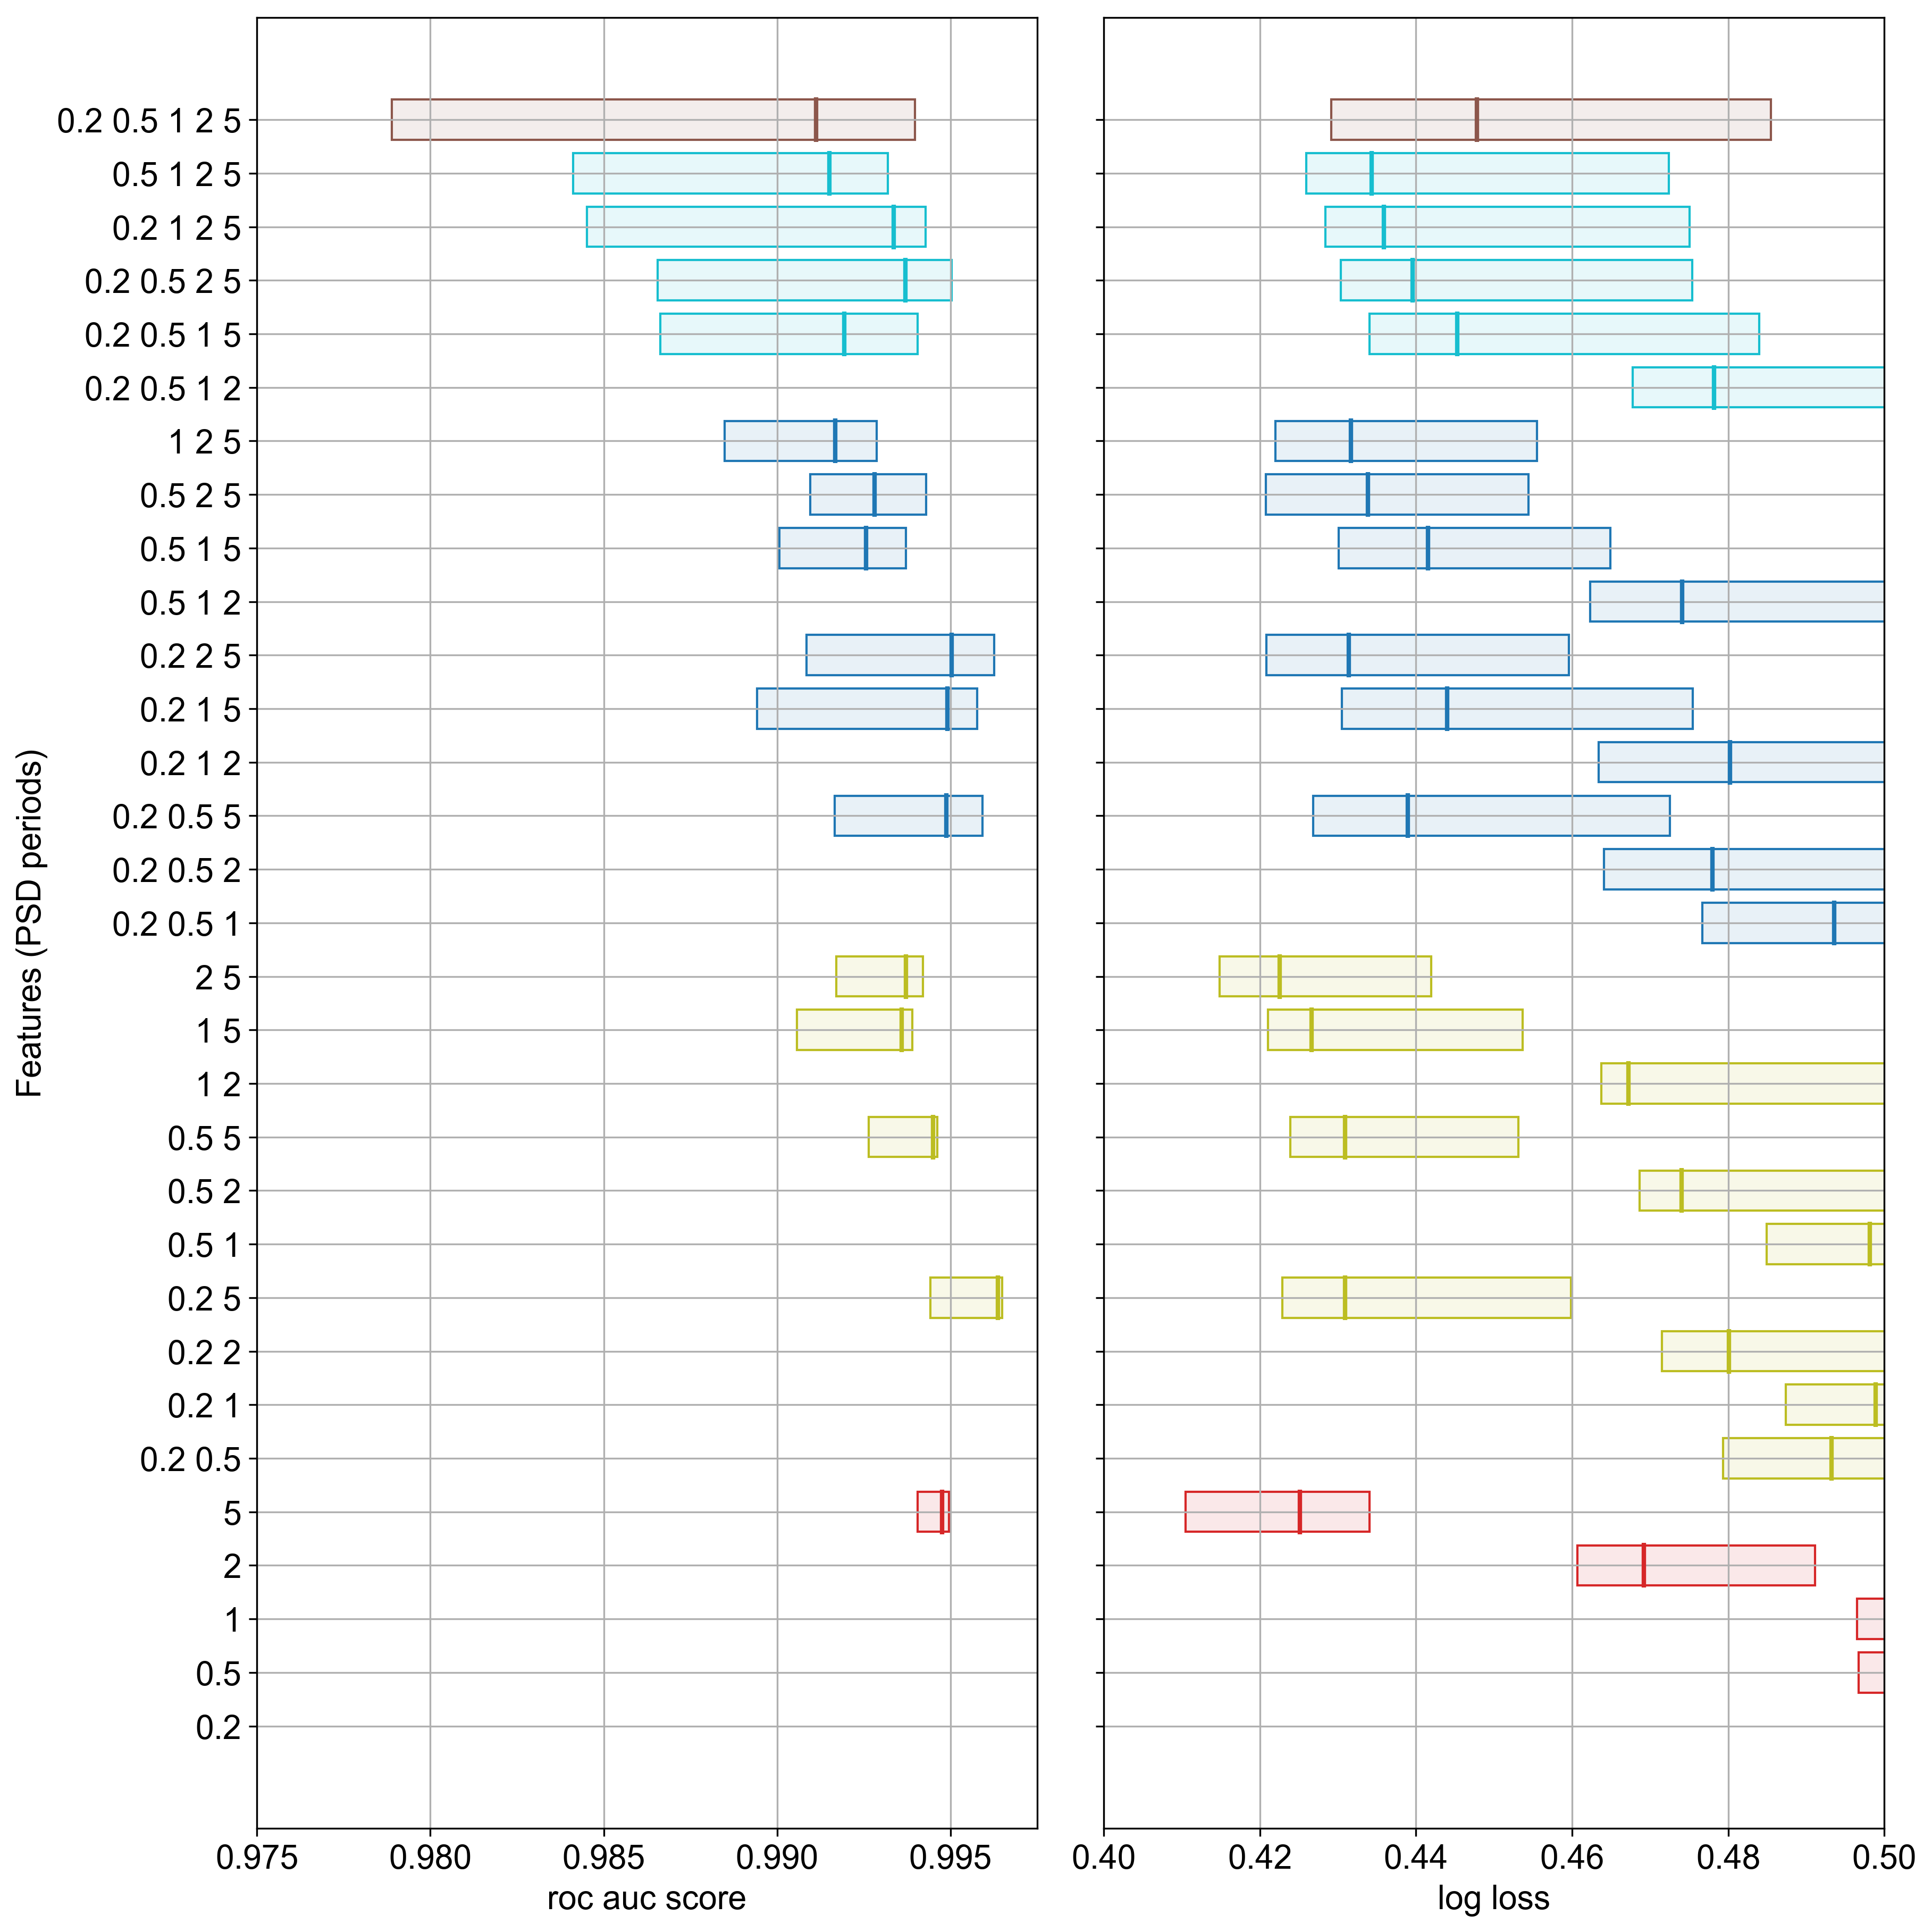

In [3]:
import matplotlib
importlib.reload(matplotlib)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 15
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'helvetica,arial'

# score_names = ['roc_auc_score', 'average_precision_score', 'log_loss']
score_names = ['roc_auc_score', 'log_loss']

# base colors are alternate after inspecting them in a grayscale screen
# to make them recognizable also in black and white printouts:
basecolors = [
    'tab:red',
    'tab:olive',
    'tab:blue',
    'tab:cyan',
    'tab:brown',
    'tab:green',
    'tab:orange',
    'tab:pink',
    'tab:purple',
    'tab:gray',
]

fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(1, len(score_names))
                      #height_ratios=heights,
                      #width_ratios=[1, 1, 1])

for j, score_name in enumerate(score_names):
    ax = fig.add_subplot(gs[0, j])
    for i, feat_tuple in enumerate(feat_tuples):
        df_ = get_metrics(feat_tuple)
        min_, median, max_ =  df_[score_name].min(), df_[score_name].median(), df_[score_name].max()

        xerr = [[median-min_], [max_-median]]
        color = basecolors[len(feat_tuple)-1]
        
        # barh(self, y, width, height=0.8, left=None, *, align='center', **kwargs)[source]
        ax.barh(i, left=min_, width=max_-min_, height=0.75, alpha=0.1, color=color, linewidth=0)
        ax.barh(i, left=min_, width=max_-min_, height=0.75, alpha=1, fill=False, ec=color, linewidth=1)
        
        ax.errorbar(median, i, xerr=xerr, color=color,
                    marker='|', capsize=0,
                    linewidth=0, elinewidth=0, capthick=0, markersize=20, mew=2)
        
        
        ax.set_yticks(list(range(len(feat_tuples))))
        if j == 0:
            ax.set_ylabel('Features (PSD periods)')
            ax.set_yticklabels(' '.join(_) for _ in feat_tuples)  # ["".join("2.2f" % _ for _ in get_periods(lbl)) for lbl in labels])
            ax.set_xlim([.975, .9975])
        else:
            ax.set_yticklabels([])

        if score_name == 'roc_auc_score':
            ax.set_xlim([.975, .9975])
        elif score_name == 'average_precision_score':
            ax.set_xlim([.975, .9975])
        elif score_name == 'log_loss':
            ax.set_xlim([.4, .5])
         
        ax.set_xlabel(score_name.replace('_', ' '))
        ax.grid()

In [4]:
# Let's do  acheck of the different scores and variability
for psds in [(2, 5), (0.2, 5), (5,)]:
    print()
    print('PERIODS: ' + str(psds))
    for meas in ['roc_auc_score', 'average_precision_score', 'log_loss']:
        min_, max_ = get_metrics(psds)[meas].min(), get_metrics(psds)[meas].max()
        range_ = np.abs(max_ - min_)
        print("%s has a maximum abs. difference of %f (%f -> %f)" % (meas, range_, min_, max_))
    




PERIODS: (2, 5)
roc_auc_score has a maximum abs. difference of 0.002506 (0.991702 -> 0.994208)
average_precision_score has a maximum abs. difference of 0.004690 (0.990575 -> 0.995265)
log_loss has a maximum abs. difference of 0.027116 (0.414835 -> 0.441951)

PERIODS: (0.2, 5)
roc_auc_score has a maximum abs. difference of 0.002080 (0.994411 -> 0.996491)
average_precision_score has a maximum abs. difference of 0.003000 (0.993762 -> 0.996762)
log_loss has a maximum abs. difference of 0.037034 (0.422850 -> 0.459884)

PERIODS: (5,)
roc_auc_score has a maximum abs. difference of 0.000903 (0.994056 -> 0.994959)
average_precision_score has a maximum abs. difference of 0.001343 (0.994297 -> 0.995640)
log_loss has a maximum abs. difference of 0.023577 (0.410490 -> 0.434066)


In [5]:
# print the evaluation metrics jsut to inspect it:
opt = pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', 130)
sem_df.sort_values(['roc_auc_score'], ascending=False)[['model', 'roc_auc_score', 'log_loss']]

,model,roc_auc_score,log_loss
142,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_esti...",0.996491,0.427080
135,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_esti...",0.996444,0.425237
141,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_esti...",0.996418,0.422850
143,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_esti...",0.996387,0.427758
136,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_esti...",0.996361,0.430935
133,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=81...",0.996260,0.420809
79,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@0.5sec,psd@5sec&behaviour=new&contamination=auto&max_samples=...",0.995927,0.426828
132,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=81...",0.995893,0.422503
137,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_esti...",0.995797,0.434835
115,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@1sec,psd@5sec&behaviour=new&contamination=auto&max_samples=81...",0.995772,0.430480
